<a href="https://colab.research.google.com/github/Bryan-Az/High-Level-GenAI-Tools/blob/main/LLaMA-Factory/llama_factory_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLaMA Factory & HuggingFace for Fine-tuning Specialized Models

In this notebook, I'll be following the guide to **train a LlaMA model with the Lora finetuning method** provided by the authors of the LlaMA-factory library in colab. LlaMA-factory provides a method to load a variety of large foundational machine learning models (such as the LlaMA model - as the name suggests). I'll further fine-tune with DPO and PPO **Reinforcement Learning via Human Feedback (RLHF)** methods.

I'll also use HuggingFace authentication to access the model backbones via LlaMA factory.

## Imports

In [ ]:
# Installing dependencies as described by the authors of LLaMA-factory
# https://colab.research.google.com/drive/1eRTPn37ltBbYsISy9Aw2NuI2Aq5CQrD9?usp=sharing#scrollTo=giM74oK1rRIH
%cd /content/
%rm -rf LLaMA-Factory
!git clone --depth 1 https://github.com/hiyouga/LLaMA-Factory.git
%cd LLaMA-Factory
%ls
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1
!pip uninstall -y jax
!pip install -e .[torch,bitsandbytes,liger-kernel]

/content
Cloning into 'LLaMA-Factory'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (315/315), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 315 (delta 80), reused 192 (delta 57), pack-reused 0 (from 0)
Receiving objects: 100% (315/315), 8.94 MiB | 18.49 MiB/s, done.
Resolving deltas: 100% (80/80), done.
/content/LLaMA-Factory
assets/       docker/      LICENSE      pyproject.toml  requirements.txt  src/
CITATION.cff  evaluation/  Makefile     README.md       scripts/          tests/
data/         examples/    MANIFEST.in  README_zh.md    setup.py
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 80.4 MB/s eta 0:00:00


In [ ]:
import torch
try:
  assert torch.cuda.is_available() is True
except AssertionError:
  print("Please set up a GPU before using LLaMA Factory: https://medium.com/mlearning-ai/training-yolov4-on-google-colab-316f8fff99c6")

## Authenticating with HuggingFace

In [ ]:
# code to authenticate with huggingface

from huggingface_hub import notebook_login
notebook_login()


## Loading the Data

In [ ]:
#updating the chat agent 'identity' training data
import json

%cd /content/LLaMA-Factory/

NAME = "Llama-3"
AUTHOR = "LLaMA Factory"

with open("data/identity.json", "r", encoding="utf-8") as f:
  dataset = json.load(f)

for sample in dataset:
  sample["output"] = sample["output"].replace("{{"+ "name" + "}}", NAME).replace("{{"+ "author" + "}}", AUTHOR)

with open("data/identity.json", "w", encoding="utf-8") as f:
  json.dump(dataset, f, indent=2, ensure_ascii=False)

/content/LLaMA-Factory


## Training (Fine-tuning) the Pre-Trained, Quantized Model Backbone

##### Manual Method of Training using the LlaMA-Factory Quantized Model

In [ ]:
import json

args_small_llama = dict(
  stage="sft",                        # do supervised fine-tuning
  do_train=True,
  model_name_or_path="unsloth/llama-3-8b-Instruct-bnb-4bit", # the model is quantized: less memory reqs
  dataset="identity, alpaca_en_demo",             # identity (chat agent) & varied text conversational data
  template="llama3",                     # use llama3 prompt template
  finetuning_type="lora",                   # use LoRA adapters to save memory
  lora_target="all",                     # attach LoRA adapters to all linear layers
  output_dir="llama3_lora",                  # the path to save LoRA adapters
  per_device_train_batch_size=2,               # the batch size
  gradient_accumulation_steps=4,               # the gradient accumulation steps
  lr_scheduler_type="cosine",                 # use cosine learning rate scheduler
  logging_steps=10,                      # log every 10 steps
  warmup_ratio=0.1,                      # use warmup scheduler
  save_steps=1000,                      # save checkpoint every 1000 steps
  learning_rate=5e-5,                     # the learning rate
  num_train_epochs=3.0,                    # the epochs of training
  max_samples=500,                      # use 500 examples in each dataset
  max_grad_norm=1.0,                     # clip gradient norm to 1.0
  loraplus_lr_ratio=16.0,                   # use LoRA+ algorithm with lambda=16.0
  fp16=True,                         # use float16 mixed precision training
)

json.dump(args_small_llama, open("RLHF_train_llama3_demo.json", "w", encoding="utf-8"), indent=2)

%cd /content/LLaMA-Factory/

!llamafactory-cli train RLHF_train_llama3_demo.json

/content/LLaMA-Factory
2024-09-09 07:36:02.760163: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 07:36:02.778190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 07:36:02.799748: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 07:36:02.806458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 07:36:02.821946: I tensorflow/core/pl

### RLHF Fine-tuning (further fine-tuning with meta human preferences)

#### Direct Policy Optimization (DPO) Fine-tuning
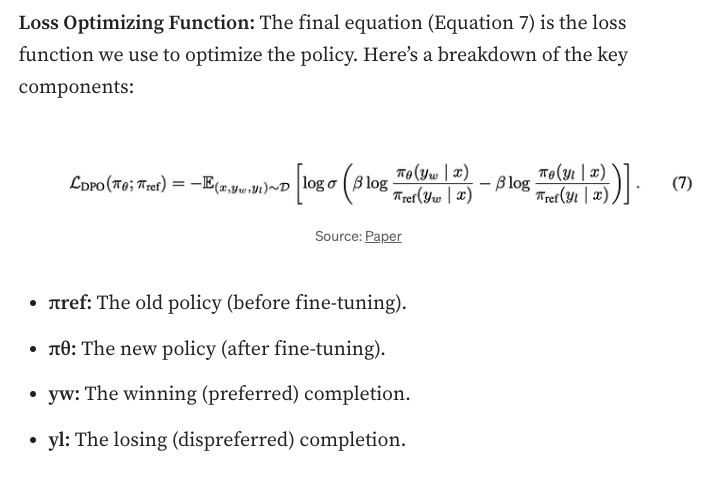

An example of the Loss Optimizing function used in DPO training. As this is the only difference between DPO training and regular training, the only change is to the loss function, therefore the training process is much simpler.


##### DPO Model Fine-tuning

In [ ]:
args_DPO_RLHF_Step2 = dict(
  stage="dpo",                        # do supervised fine-tuning
  do_train=True,
  model_name_or_path="unsloth/llama-3-8b-Instruct-bnb-4bit", # the model is not quantized: less memory reqs
  dataset="dpo_en_demo",             # identity (chat agent) & varied text conversational data
  template="llama3",                     # use llama3 prompt template
  finetuning_type="lora",                   # use LoRA adapters to save memory
  lora_target="all",                     # attach LoRA adapters to all linear layers
  output_dir="llama3_lora_DPO",                  # the path to save LoRA adapters
  per_device_train_batch_size=1,               # the batch size
  gradient_accumulation_steps=8,               # the gradient accumulation steps
  lr_scheduler_type="cosine",                 # use cosine learning rate scheduler
  logging_steps=10,                      # log every 10 steps
  warmup_ratio=0.1,                      # use warmup scheduler
  save_steps=500,                      # save checkpoint every 1000 steps
  learning_rate=5e-2,                     # the learning rate
  num_train_epochs=3.0,                    # the epochs of training
  max_samples=1000,                      # use 500 examples in each dataset
  bf16=True,
  cutoff_len=1024,
  overwrite_cache=True,
  preprocessing_num_workers=16,
  pref_beta=0.1,
  pref_loss='sigmoid',
  overwrite_output_dir=True,
  ddp_timeout=180000000,
  val_size=0.1,
  per_device_eval_batch_size=1,
  eval_strategy='steps',
  eval_steps=500,
)

In [ ]:
json.dump(args_DPO_RLHF_Step2, open("RLHF_train_llama3_demo_DPO_Step2.json", "w", encoding="utf-8"), indent=2)

%cd /content/LLaMA-Factory/

!llamafactory-cli train RLHF_train_llama3_demo_DPO_Step2.json # using the quantized LlaMA factory model

/content/LLaMA-Factory
2024-09-09 07:58:03.679208: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 07:58:03.698056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 07:58:03.720427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 07:58:03.727137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 07:58:03.743390: I tensorflow/core/pl

#### Proximal Policy Optimization (PPO) Training
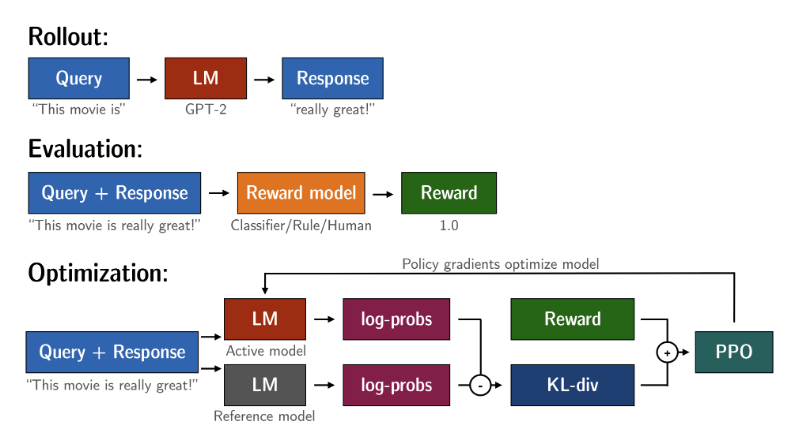

The above is a diagram of the PPO method as referenced in: https://newfacade.github.io/notes-on-reinforcement-learning/17-ppo-trl.html

PPO training has many components that make it a bit more complex than DPO training. Luckily, LLaMA-Factory provides a straight-forward way to implement it.

##### Reward Model Training

In [ ]:
args_PPO_RLHF_Step1 = dict(
  stage="rm",                        # do supervised fine-tuning
  do_train=True,
  reward_model= 'llama3_lora',
  model_name_or_path="unsloth/llama-3-8b-Instruct-bnb-4bit", # the model is not quantized: less memory reqs
  dataset="dpo_en_demo",             # identity (chat agent) & varied text conversational data
  template="llama3",                     # use llama3 prompt template
  finetuning_type="lora",                   # use LoRA adapters to save memory
  lora_target="all",                     # attach LoRA adapters to all linear layers
  output_dir="llama3_lora_PPO_reward",                  # the path to save LoRA adapters
  per_device_train_batch_size=1,               # the batch size
  gradient_accumulation_steps=8,               # the gradient accumulation steps
  lr_scheduler_type="cosine",                 # use cosine learning rate scheduler
  logging_steps=10,                      # log every 10 steps
  warmup_ratio=0.1,                      # use warmup scheduler
  save_steps=500,                      # save checkpoint every 1000 steps
  learning_rate=1e-5,                     # the learning rate
  num_train_epochs=3.0,                    # the epochs of training
  plot_loss=True,
  max_samples=1000,                      # use 500 examples in each dataset
  bf16=True,
  cutoff_len=1024,
  overwrite_cache=True,
  preprocessing_num_workers=16,
  pref_beta=0.1,
  pref_loss='sigmoid',
  overwrite_output_dir=True,
  ddp_timeout=180000000,
  val_size=0.1,
  per_device_eval_batch_size=1,
  eval_strategy='steps',
  eval_steps=500,
  max_new_tokens=512,
  top_k=0,
  top_p=0.9,
)

In [ ]:
json.dump(args_PPO_RLHF_Step1, open("RLHF_train_llama3_demo_PPO_Step1.json", "w", encoding="utf-8"), indent=2)

%cd /content/LLaMA-Factory/

!llamafactory-cli train RLHF_train_llama3_demo_PPO_Step1.json

/content/LLaMA-Factory
2024-09-09 08:47:27.634232: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 08:47:27.653136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 08:47:27.675307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 08:47:27.682115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 08:47:27.698413: I tensorflow/core/pl

##### PPO Model Fine-tuning

In [ ]:
args_PPO_RLHF_Step2 = dict(
  stage="ppo",                        # do supervised fine-tuning
  do_train=True,
  reward_model= 'llama3_lora_PPO_reward',
  model_name_or_path="unsloth/llama-3-8b-Instruct-bnb-4bit", # the model is not quantized: less memory reqs
  dataset="identity,alpaca_en_demo",             # identity (chat agent) & varied text conversational data
  template="llama3",                     # use llama3 prompt template
  finetuning_type="lora",                   # use LoRA adapters to save memory
  lora_target="all",                     # attach LoRA adapters to all linear layers
  output_dir="llama3_lora_PPO",                  # the path to save LoRA adapters
  per_device_train_batch_size=1,               # the batch size
  gradient_accumulation_steps=8,               # the gradient accumulation steps
  lr_scheduler_type="cosine",                 # use cosine learning rate scheduler
  logging_steps=10,                      # log every 10 steps
  warmup_ratio=0.1,                      # use warmup scheduler
  save_steps=500,                      # save checkpoint every 1000 steps
  learning_rate=1e-5,                     # the learning rate
  num_train_epochs=3.0,                    # the epochs of training
  plot_loss=True,
  max_samples=1000,                      # use 500 examples in each dataset
  bf16=True,
  cutoff_len=1024,
  overwrite_cache=True,
  preprocessing_num_workers=16,
  overwrite_output_dir=True,
  ddp_timeout=180000000,
  per_device_eval_batch_size=1,
  max_new_tokens=512,
  top_k=0,
  top_p=0.9,
)

In [ ]:
json.dump(args_PPO_RLHF_Step2, open("RLHF_train_llama3_demo_PPO_Step2.json", "w", encoding="utf-8"), indent=2)

%cd /content/LLaMA-Factory/

!llamafactory-cli train RLHF_train_llama3_demo_PPO_Step2.json

/content/LLaMA-Factory
2024-09-09 09:21:24.854428: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 09:21:24.874664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 09:21:24.896363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 09:21:24.903063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 09:21:24.918992: I tensorflow/core/pl

## Loading the Model for Inference
Due to memory issues within the Colab environment having a cap of 15gb (on the paid version), let's just evaluate the SFT model previously loaded.

In [ ]:
!pip install llamafactory

In [ ]:
!pip show llamafactory

Name: llamafactory
Version: 0.9.0
Summary: Easy-to-use LLM fine-tuning framework
Home-page: https://github.com/hiyouga/LLaMA-Factory
Author: hiyouga
Author-email: hiyouga@buaa.edu.cn
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Editable project location: /content/LLaMA-Factory
Requires: accelerate, datasets, einops, fastapi, fire, gradio, matplotlib, numpy, packaging, pandas, peft, protobuf, pydantic, pyyaml, scipy, sentencepiece, sse-starlette, tiktoken, transformers, trl, uvicorn
Required-by: 


In [ ]:
from llamafactory.chat import ChatModel
from llamafactory.extras.misc import torch_gc

%cd /content/LLaMA-Factory/

args = dict(
  model_name_or_path="llama3_lora_PPO", # using the Supervised Fine-tuning Model (technically not the PPO model)
  adapter_name_or_path="llama3_lora",            # load the saved LoRA adapters
  template="llama3",                     # same to the one in training
  finetuning_type="lora",                  # same to the one in training
  quantization_bit=4,                    # load 4-bit quantized model
)
chat_model = ChatModel(args)

messages = []
print("Welcome to the CLI application, use `clear` to remove the history, use `exit` to exit the application.")
while True:
  query = input("\nUser: ")
  if query.strip() == "exit":
    break
  if query.strip() == "clear":
    messages = []
    torch_gc()
    print("History has been removed.")
    continue

  messages.append({"role": "user", "content": query})
  print("Assistant: ", end="", flush=True)

  response = ""
  for new_text in chat_model.stream_chat(messages):
    print(new_text, end="", flush=True)
    response += new_text
  print()
  messages.append({"role": "assistant", "content": response})

torch_gc()

ModuleNotFoundError: No module named 'llamafactory'

## Merge the LoRA adapter and optionally upload model

NOTE: the Colab free version has merely 12GB RAM, where merging LoRA of a 8B model needs at least 18GB RAM, thus you **cannot** perform it in the free version.

In [ ]:
!huggingface-cli login

In [ ]:
import json

args = dict(
  model_name_or_path="meta-llama/Meta-Llama-3-8B-Instruct", # use official non-quantized Llama-3-8B-Instruct model
  adapter_name_or_path="llama3_lora",            # load the saved LoRA adapters
  template="llama3",                     # same to the one in training
  finetuning_type="lora",                  # same to the one in training
  export_dir="llama3_lora_merged",              # the path to save the merged model
  export_size=2,                       # the file shard size (in GB) of the merged model
  export_device="cpu",                    # the device used in export, can be chosen from `cpu` and `cuda`
  #export_hub_model_id="your_id/your_model",         # the Hugging Face hub ID to upload model
)

json.dump(args, open("merge_llama3.json", "w", encoding="utf-8"), indent=2)

%cd /content/LLaMA-Factory/

!llamafactory-cli export merge_llama3.json